In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import os
import json
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
import tb_gene_signature_pipeline.network_analysis as na
import tb_gene_signature_pipeline.plotting as tbplt

In [3]:
project_dir = Path.cwd().resolve().parent

In [4]:
with (project_dir / 'data' / 'datasets.json').open('r') as f:
    datasets = json.load(f)

In [5]:
with (project_dir / 'data' / 'comparisons.json').open('r') as f:
    comparisons = json.load(f)

In [6]:
with (project_dir / 'config.yml').open('r') as f:
    config = yaml.safe_load(f)

### Differential Expression Analysis

Generate per-gene differential expression statistics for each dataset and for each case/control group comparison.

In [8]:
differential_expression_results = na.run_differential_expression_analysis(log_transform_all_geo_data=False)

#### Sample expression distributions by dataset

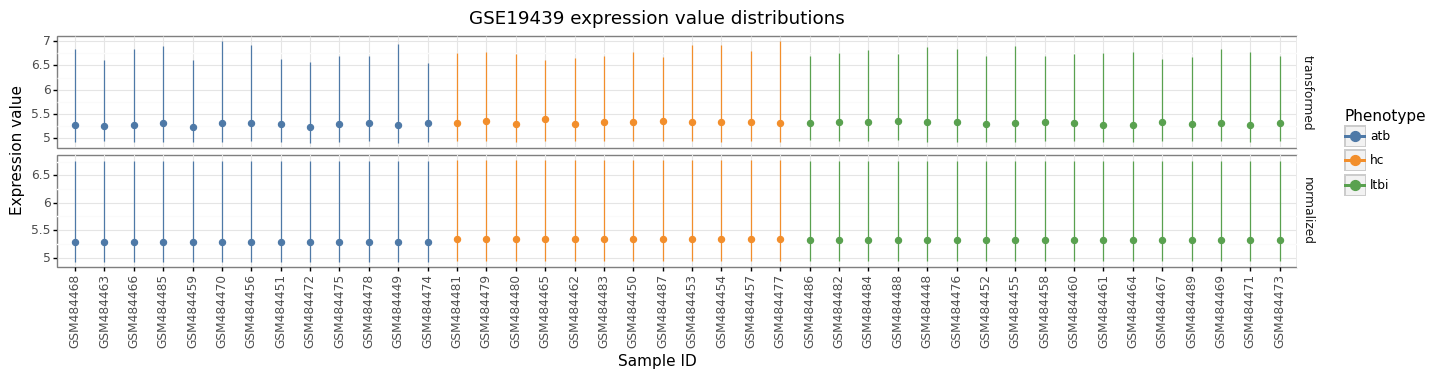

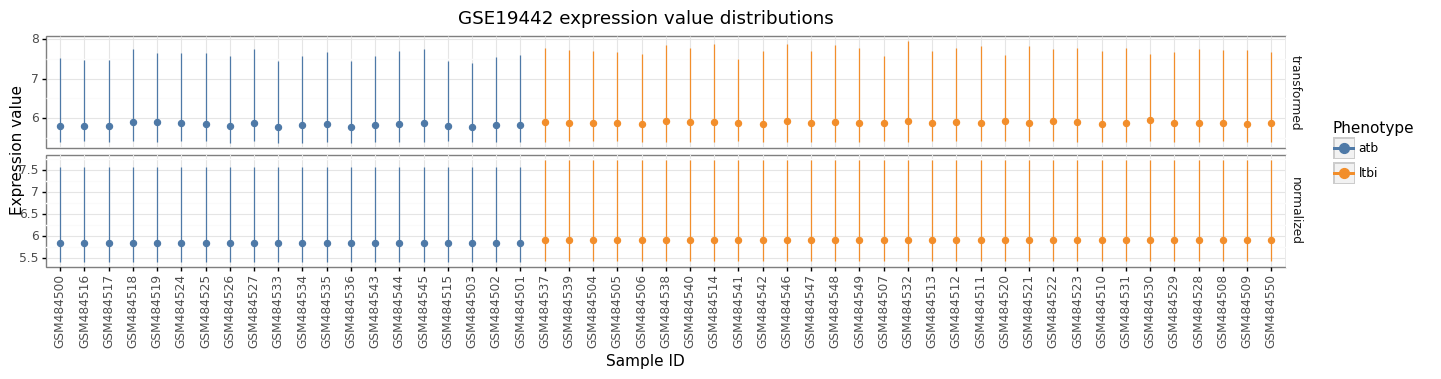

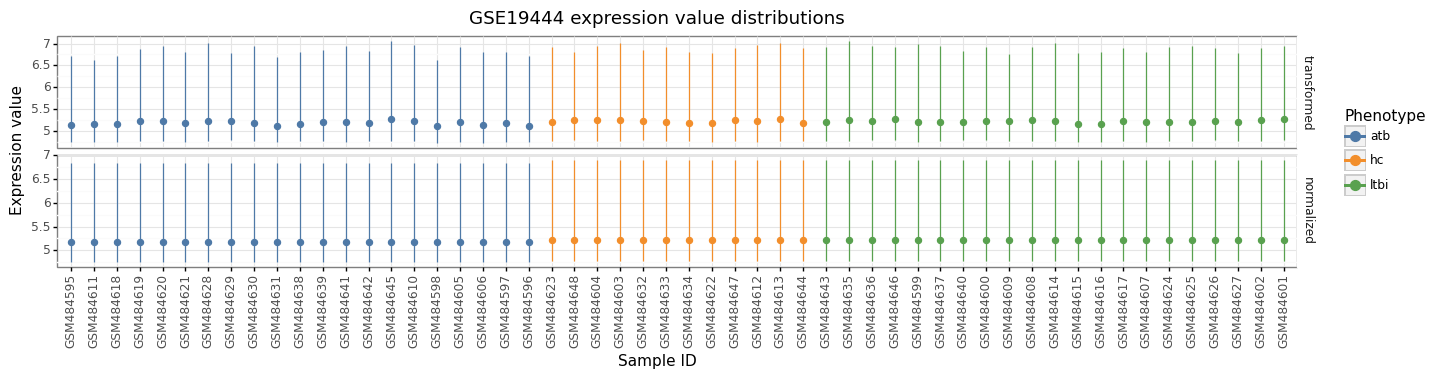

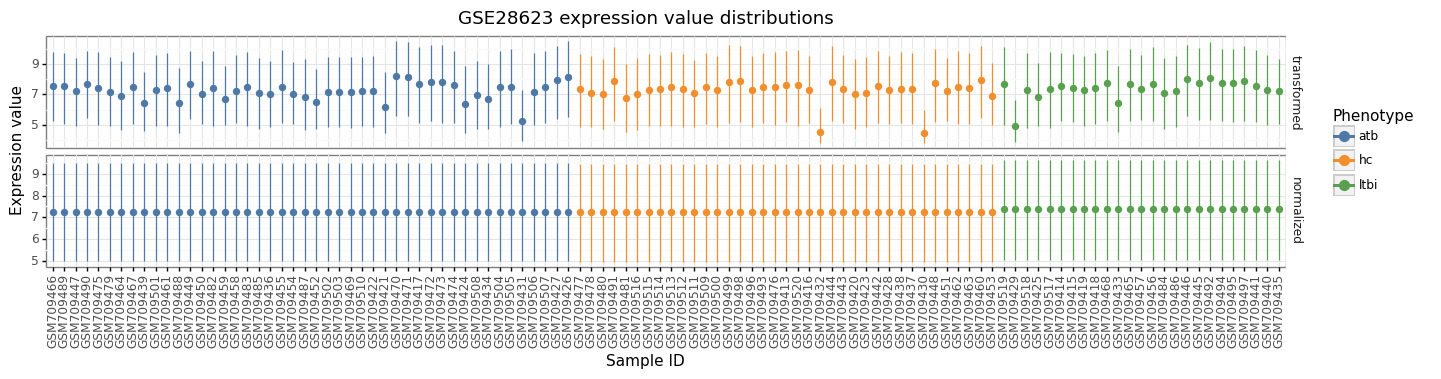

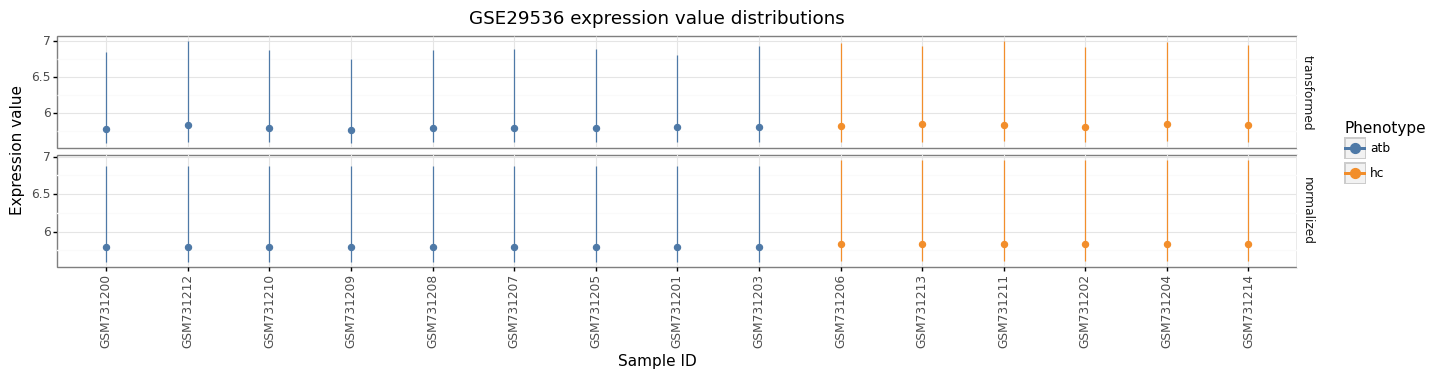

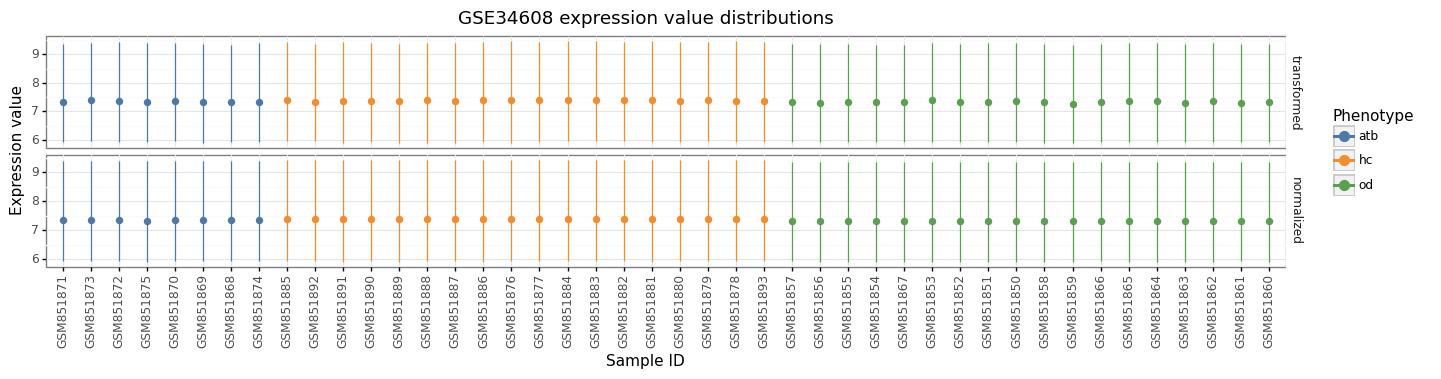

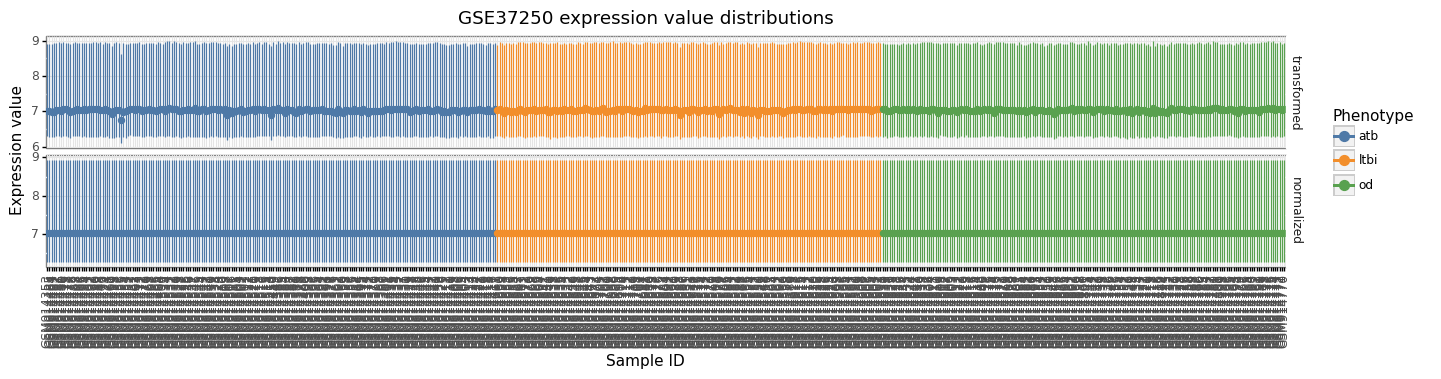

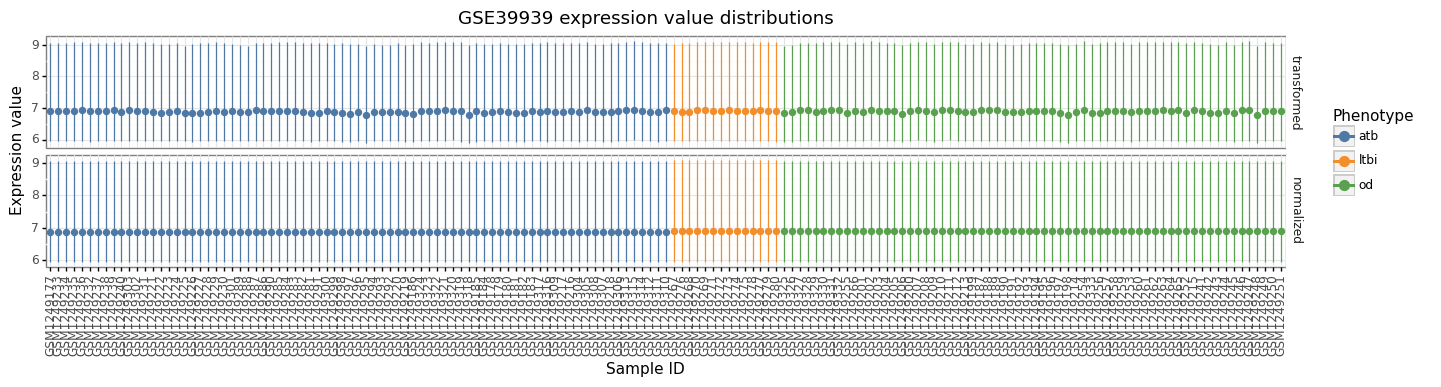

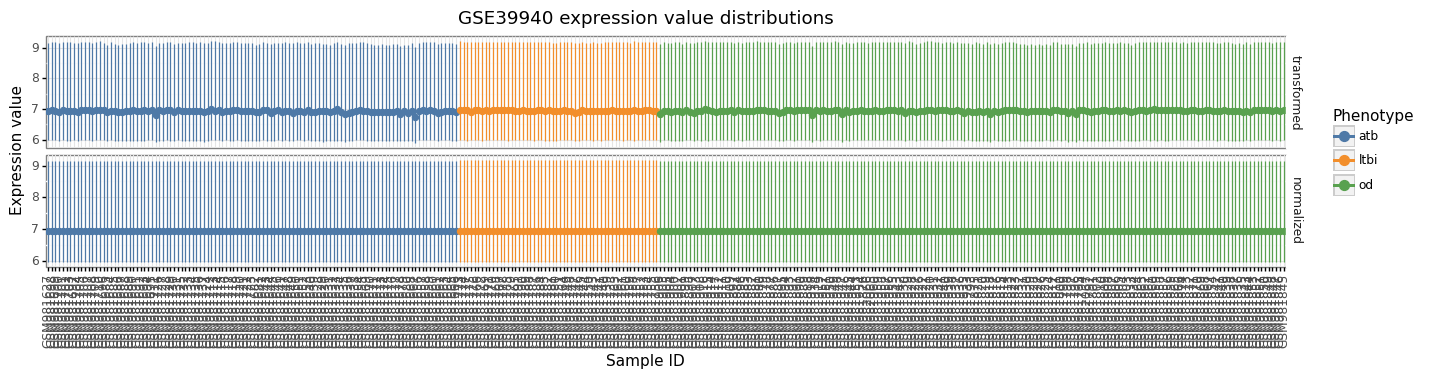

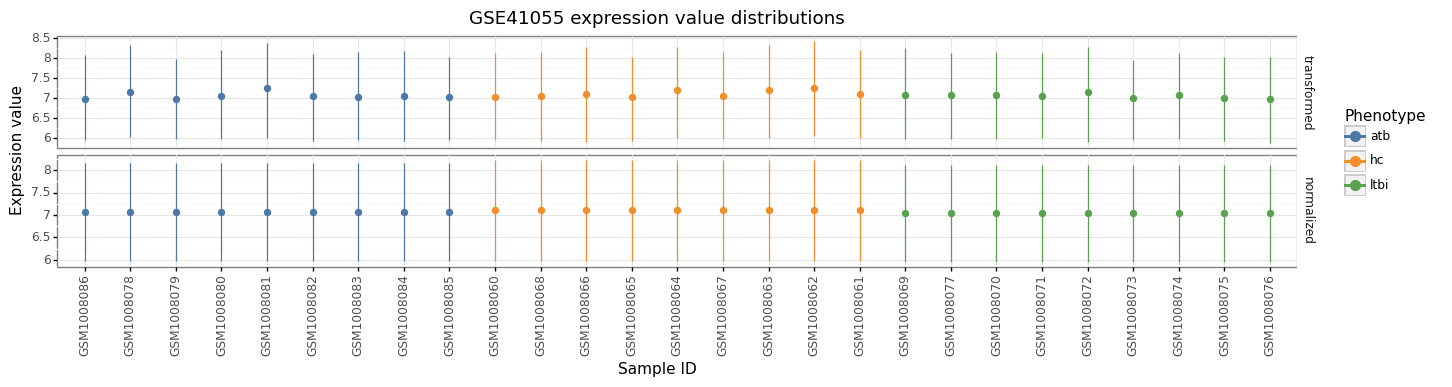

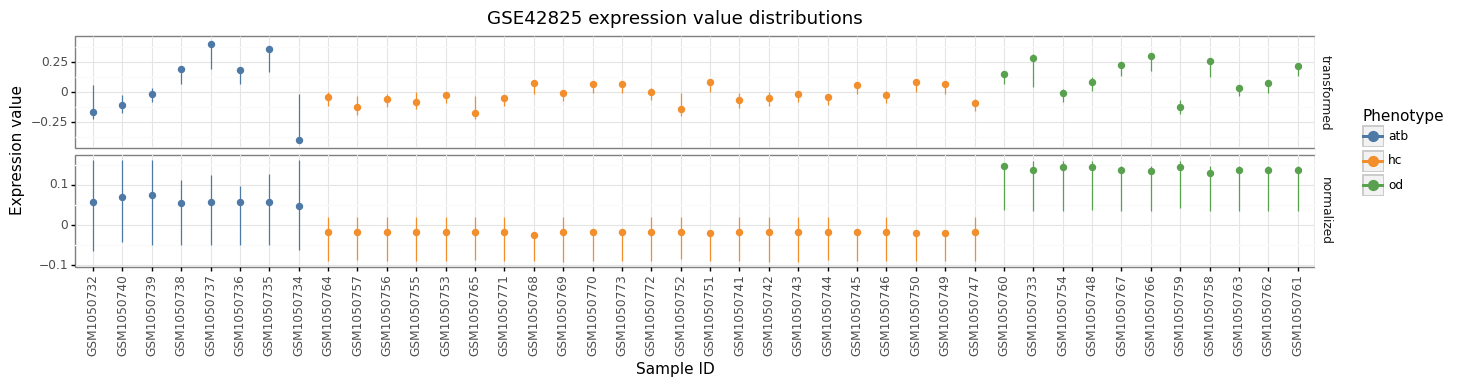

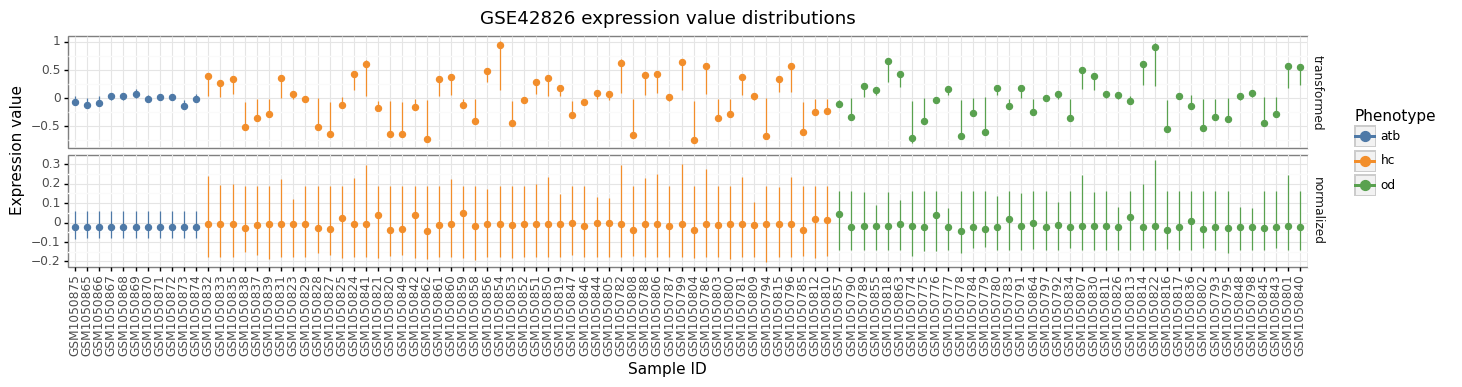

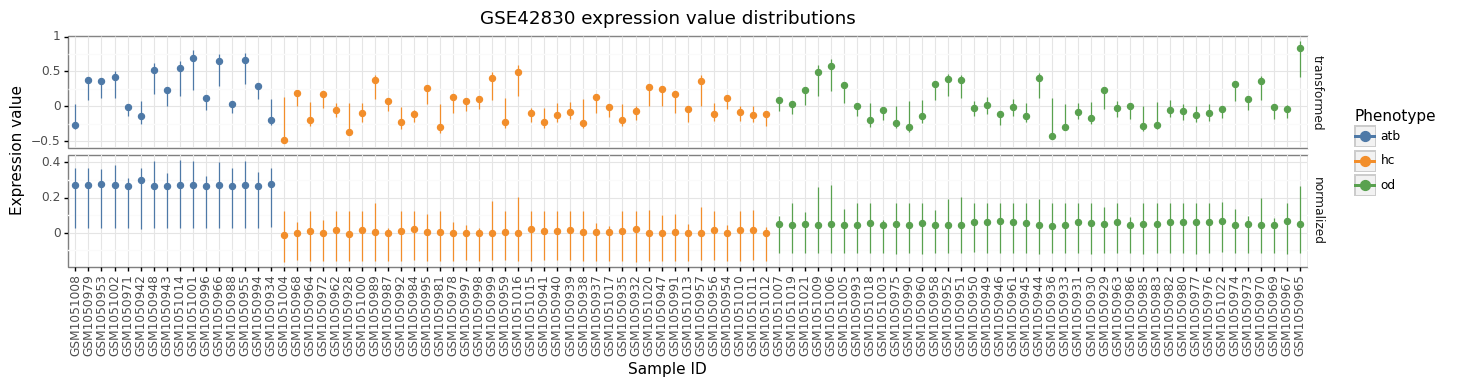

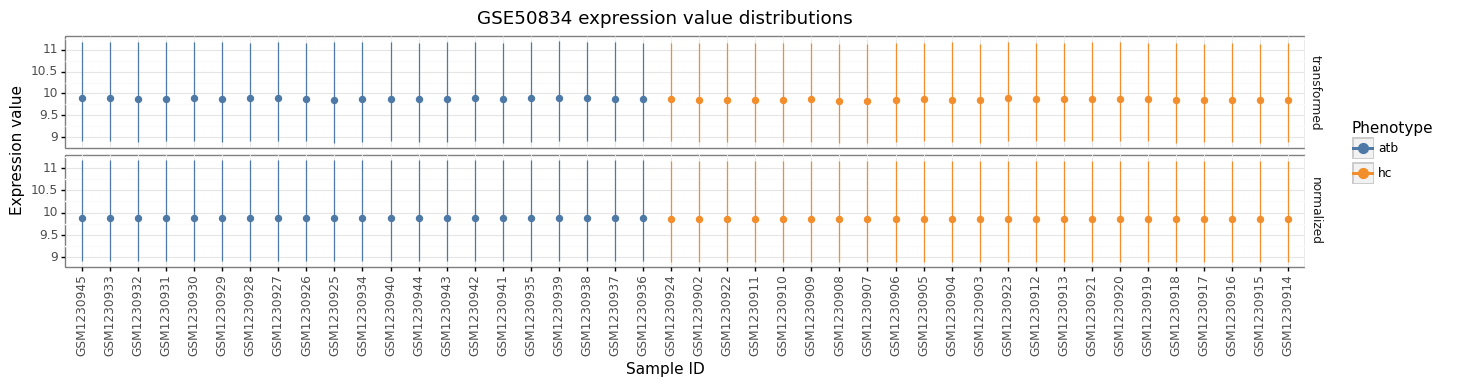

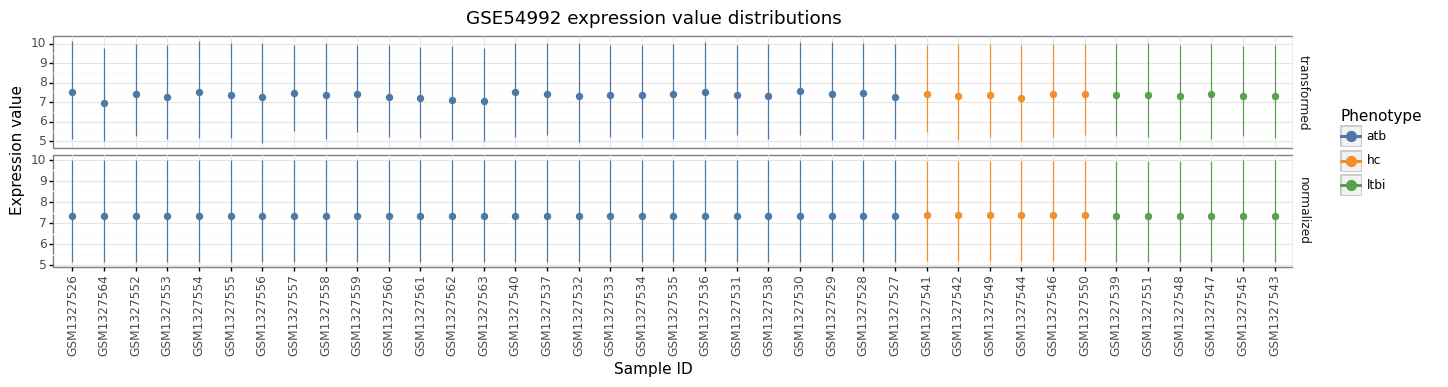

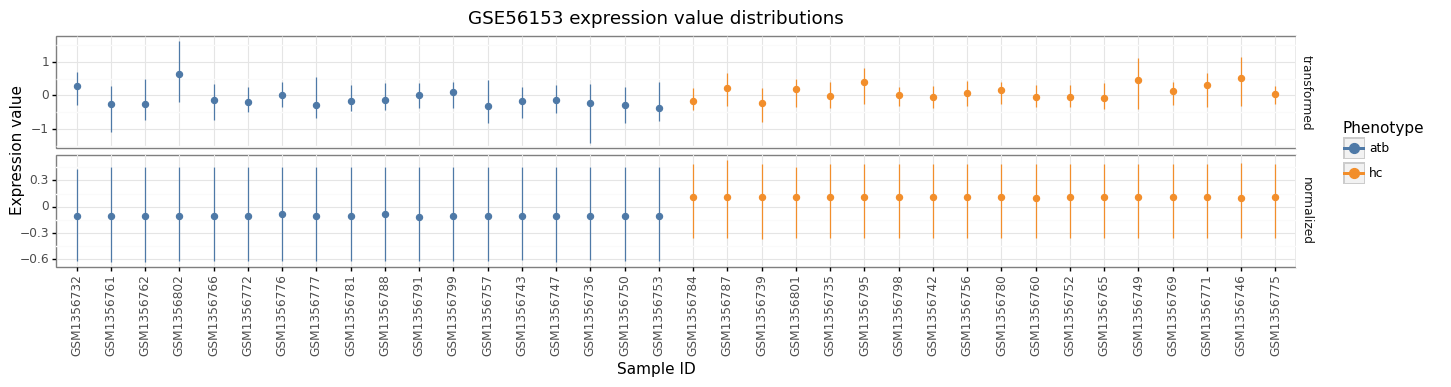

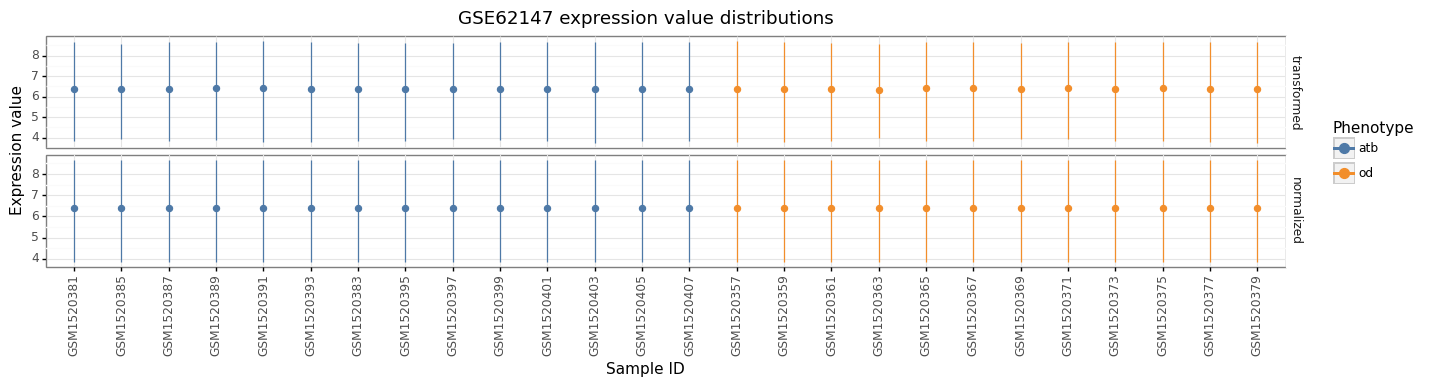

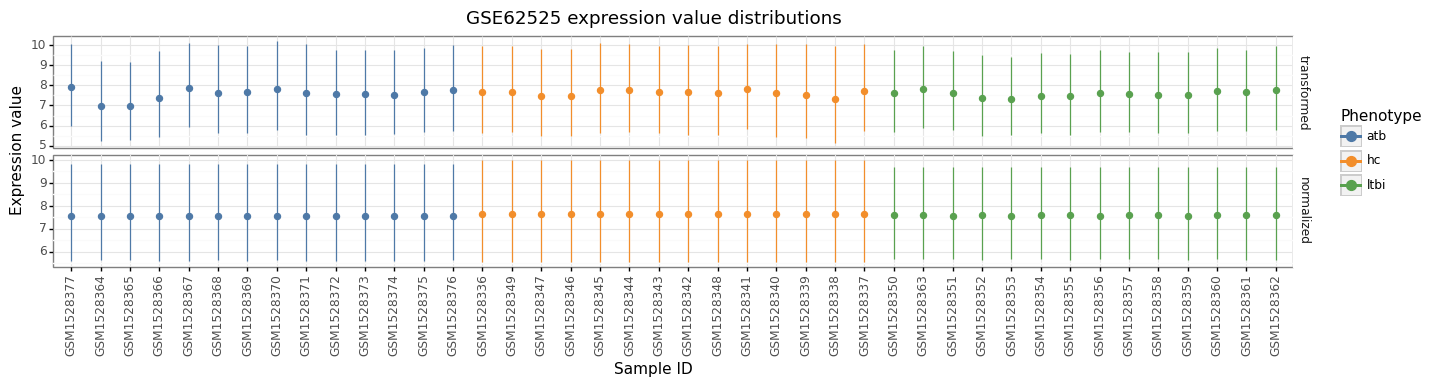

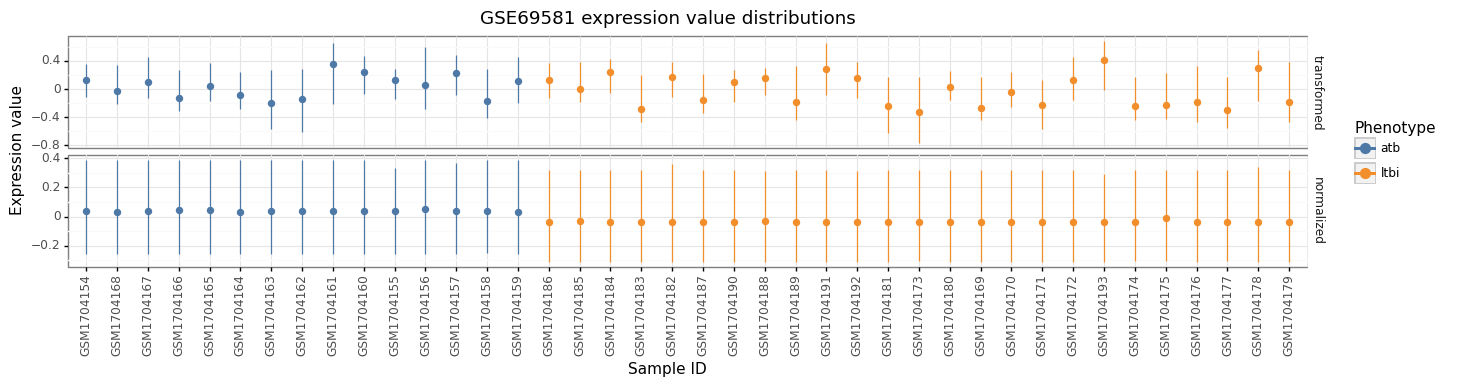

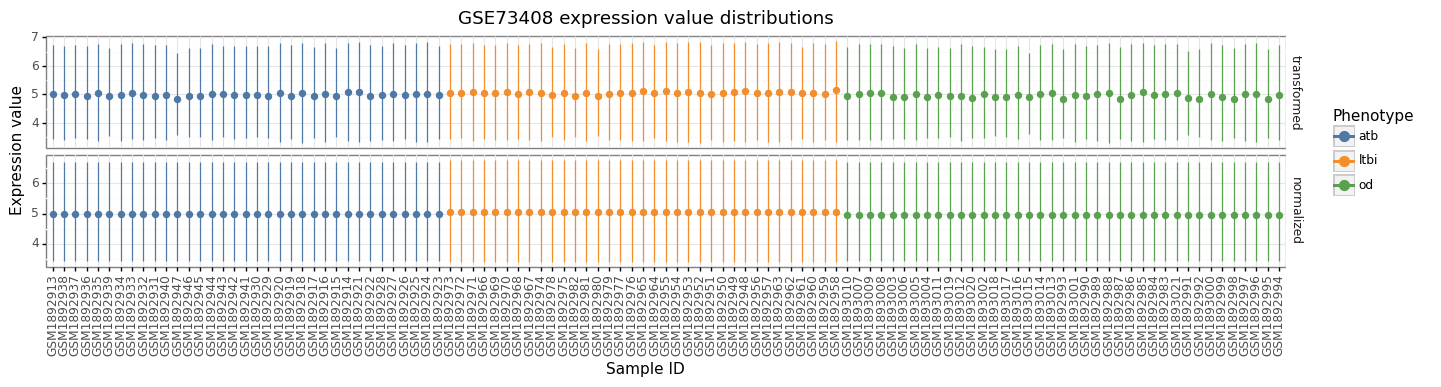

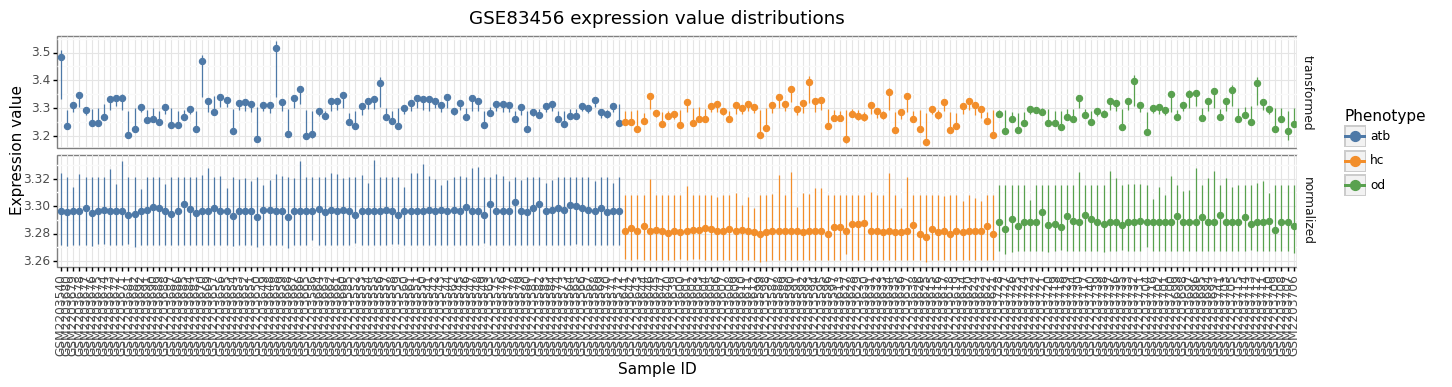

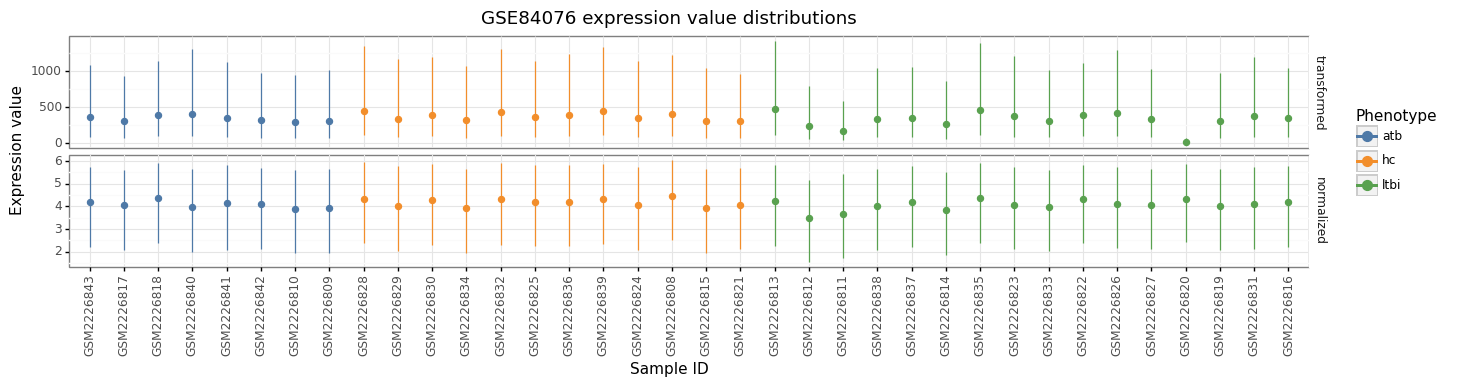

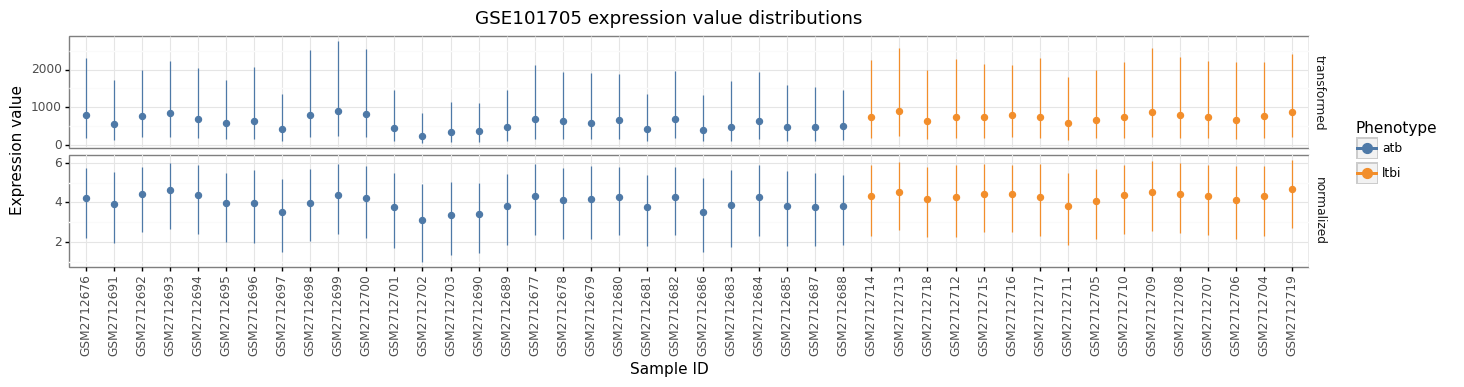

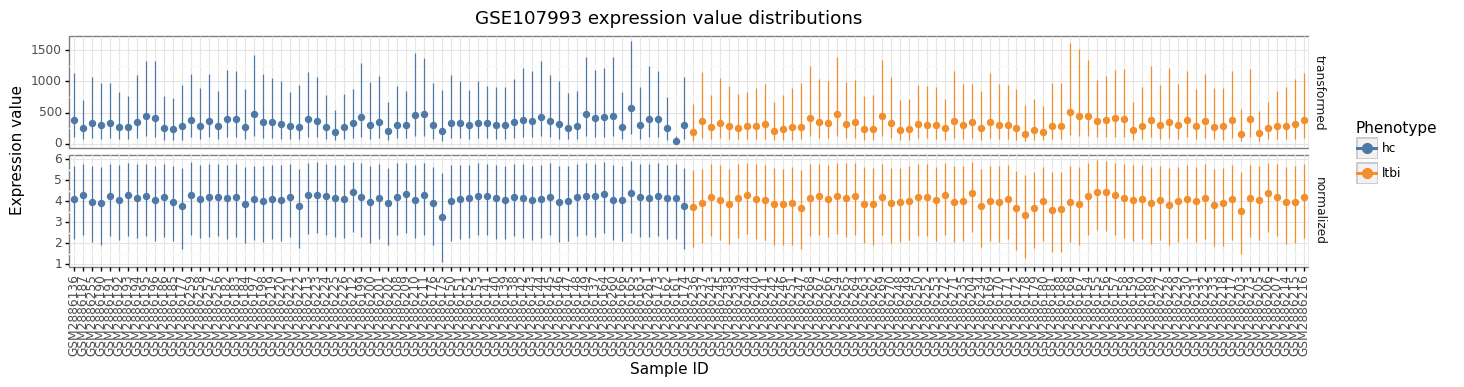

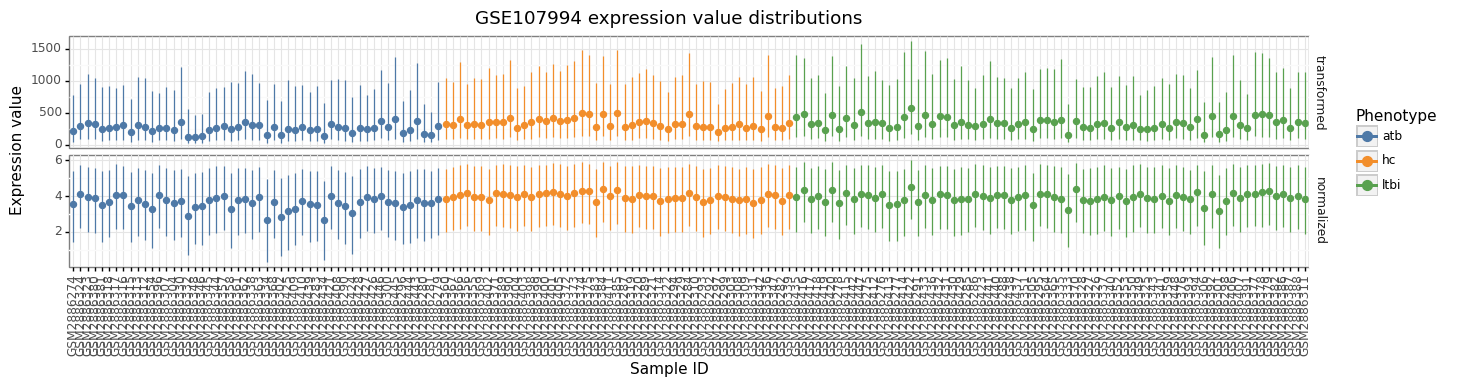

In [9]:
for dataset in datasets:
    tbplt.plot_expression_distributions(
        differential_expression_results['exprs'], gse_id=dataset['gse_id']).draw();

### Merge Differential Expression Results

Given differential expression statistics across datasets and comparisons, filter the results to include
only genes with `adj_p_val <= 0.05` and effect size `log_fc >= np.log2(1.5)`. Combine filtered log fold
change effect sizes into a ``(gene * n_comparisons)-by-dataset`` dataframe.

In [10]:
merged_results = na.merge_differential_expression_results(
    differential_expression_results['results'], adj_pval_thresh=0.05, log_fc_thresh=np.log2(1.5))

#### Plot distribution of number of datasets in which each gene is significantly differentially expressed

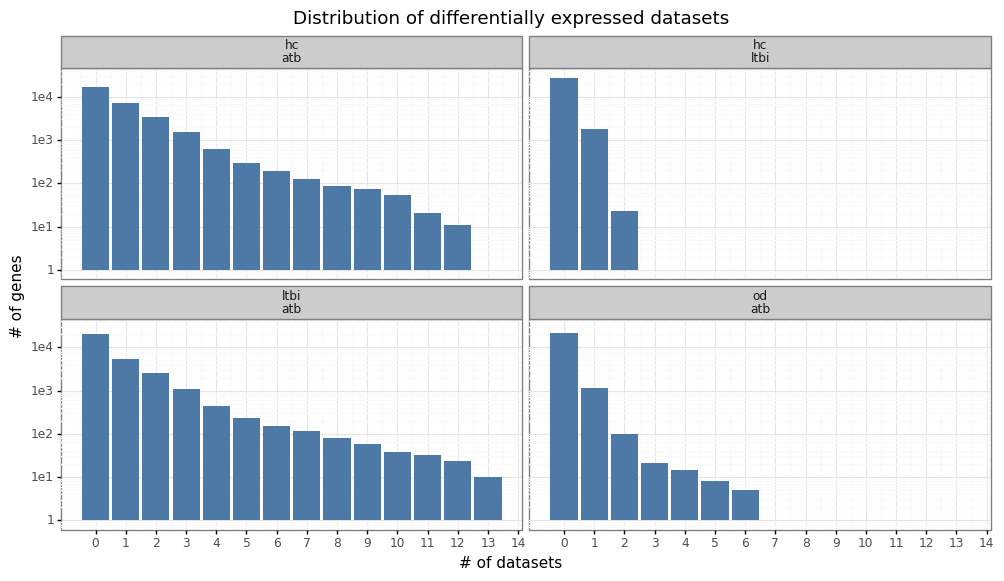

In [11]:
tbplt.plot_n_datasets_differentially_expressed(merged_results).draw();

#### Plot edge weight distributions

In [12]:
edge_weight_distributions = na.compute_edge_weight_distributions(merged_results)

In [15]:
null_edge_weight_distributions = na.generate_null_edge_weight_distributions(merged_results, n_iter=25)

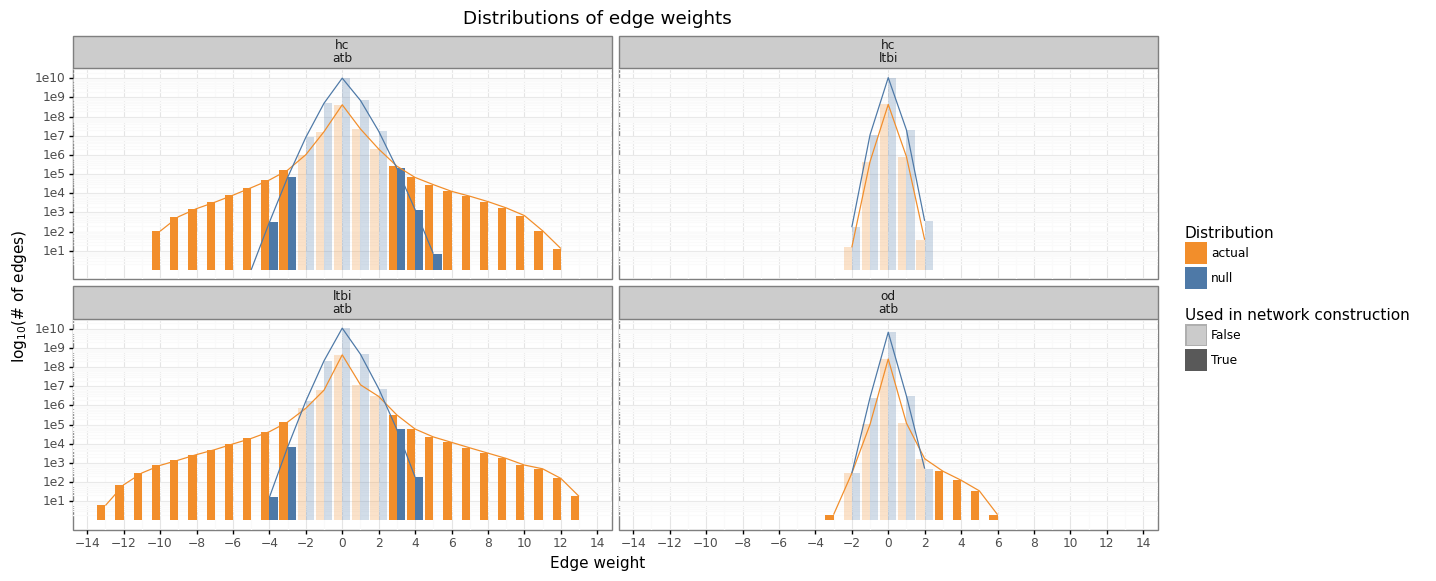

In [16]:
tbplt.plot_edge_weight_distributions(
    edge_weight_distributions, null_edge_weight_distributions).draw();

### Construct gene effect network

Use the signficant log fold change effect size estimates to construct a network where nodes correspond to genes
and an edge between two nodes represents significant differential expression for each of the two genes in the
same direction (positive or negative) in **at least 3 datasets**.

A separate network is constructed for each comparison group (`hc` vs. `atb`, etc.).

Also computes degree, weighted degree, and eigenvector centrality measures for each node in the networks.

In [17]:
networks = na.construct_networks(merged_results)

#### Plot node measures

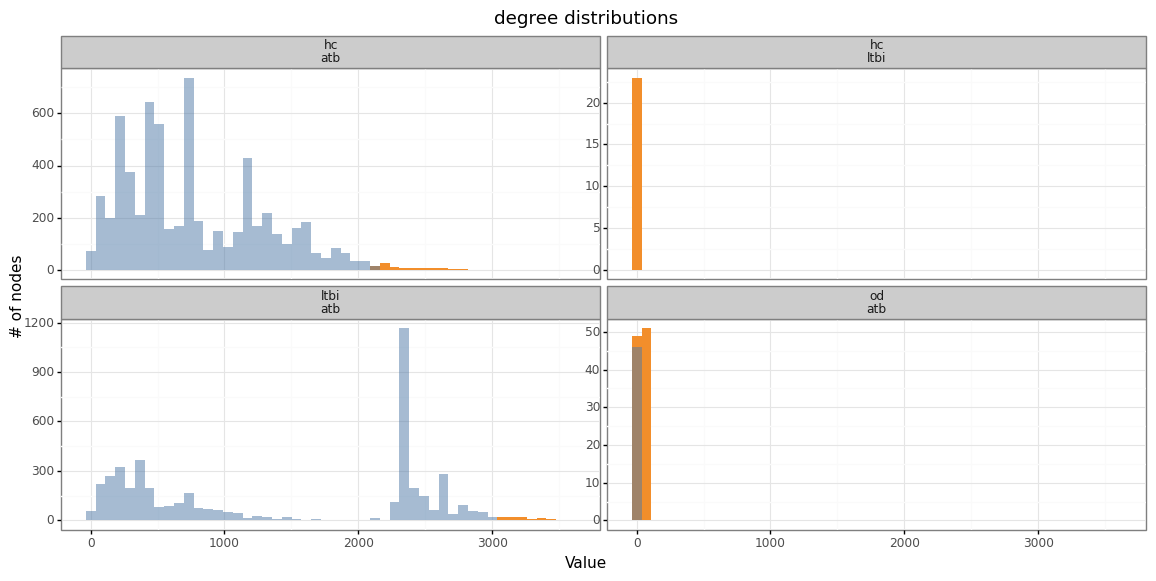

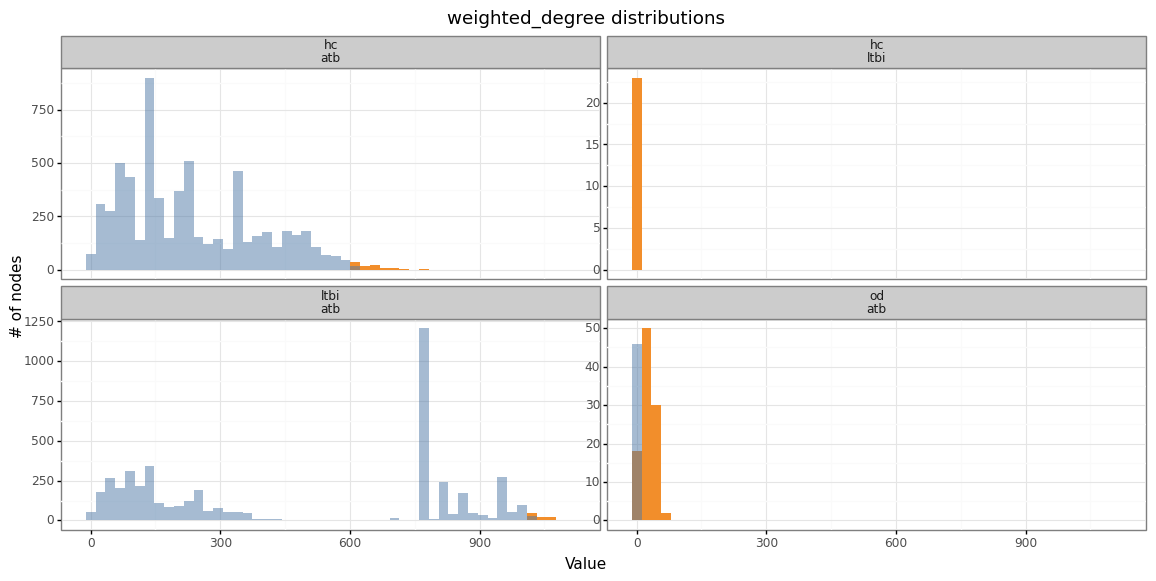

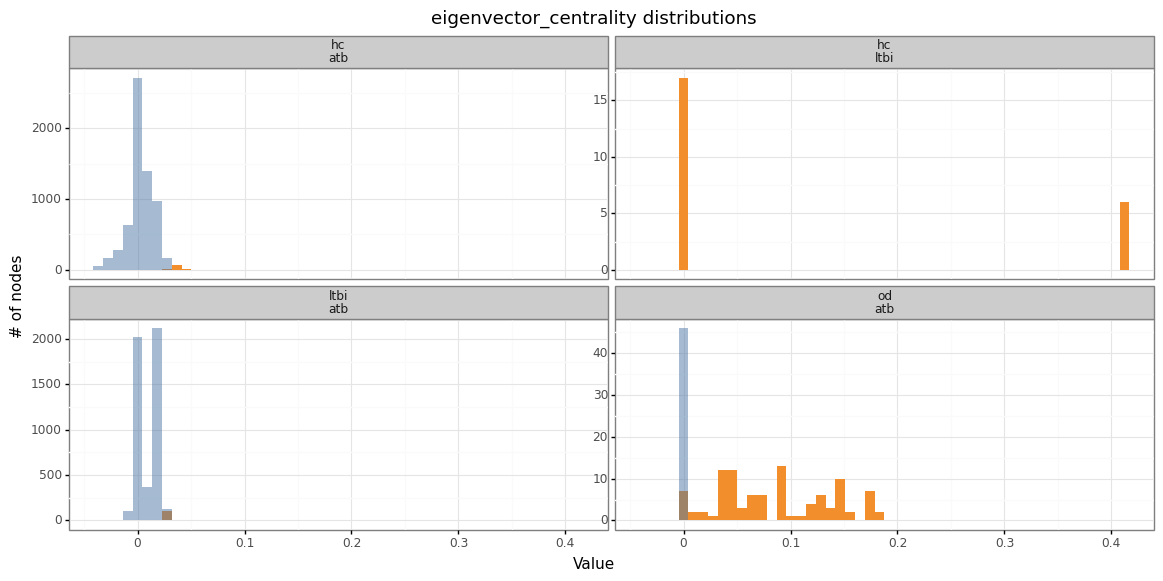

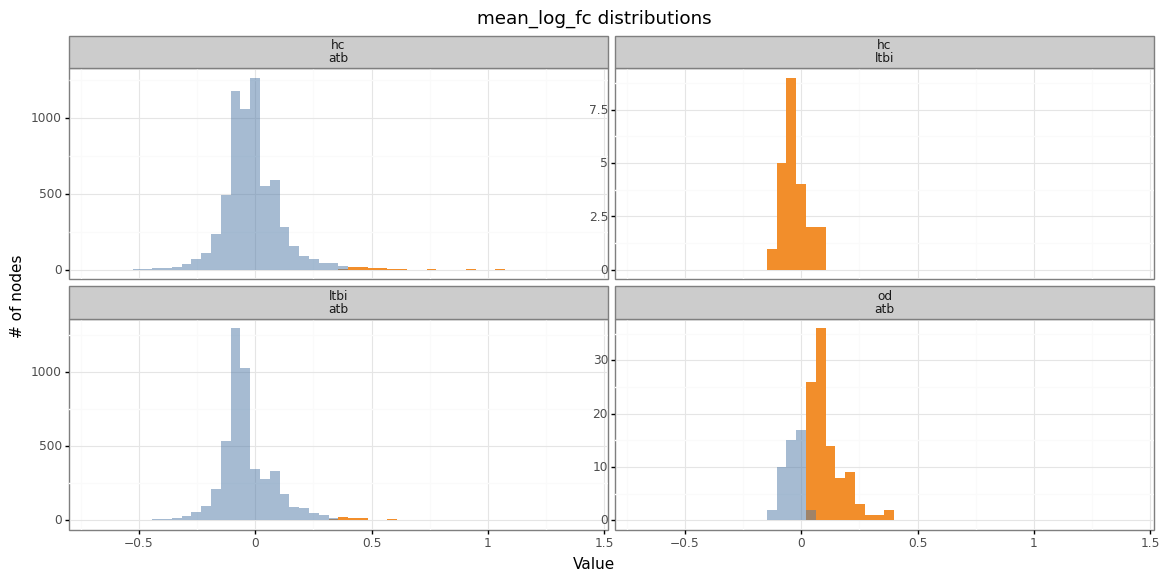

In [18]:
for measure in ['degree', 'weighted_degree', 'eigenvector_centrality', 'mean_log_fc']:
    tbplt.plot_node_measure_distributions(networks['nodes'], measure=measure, top_n=100).draw();

#### Plot mean log FC vs. node centrality measures

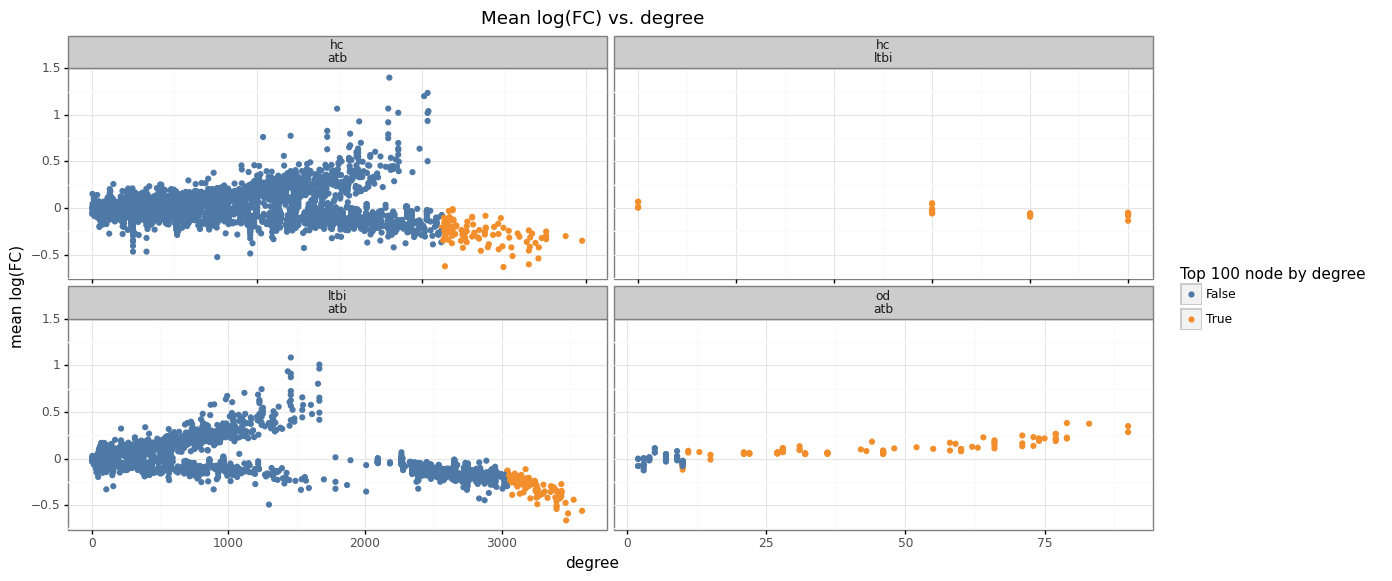

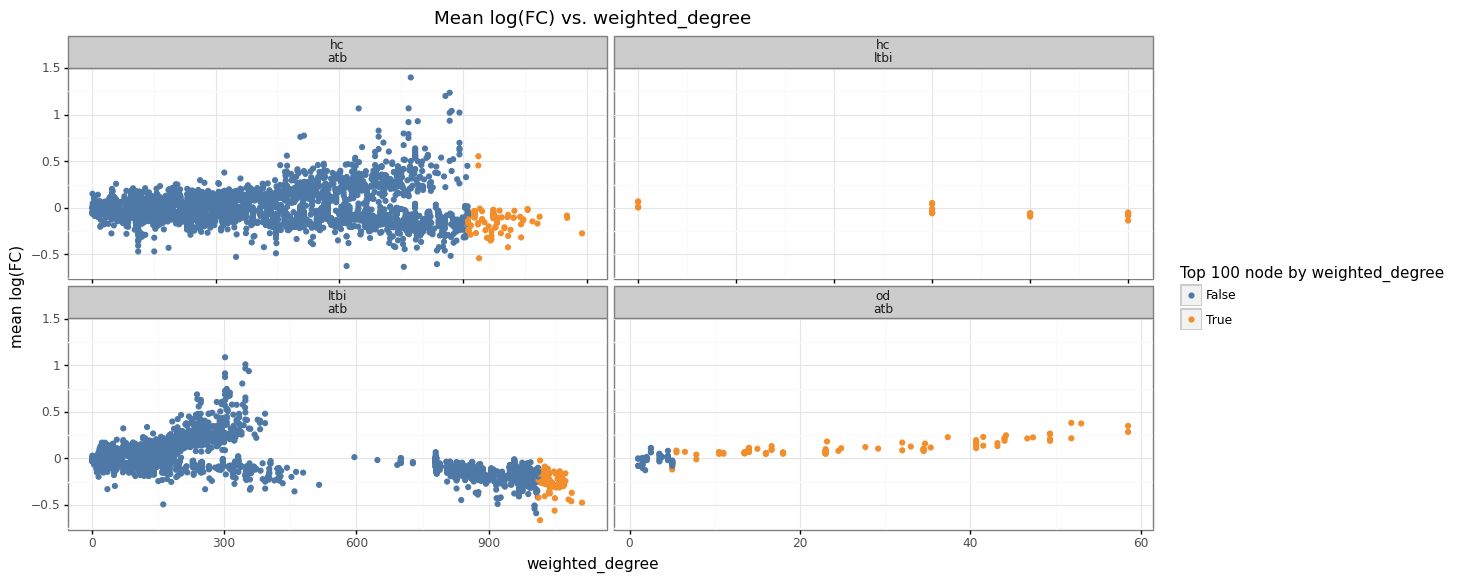

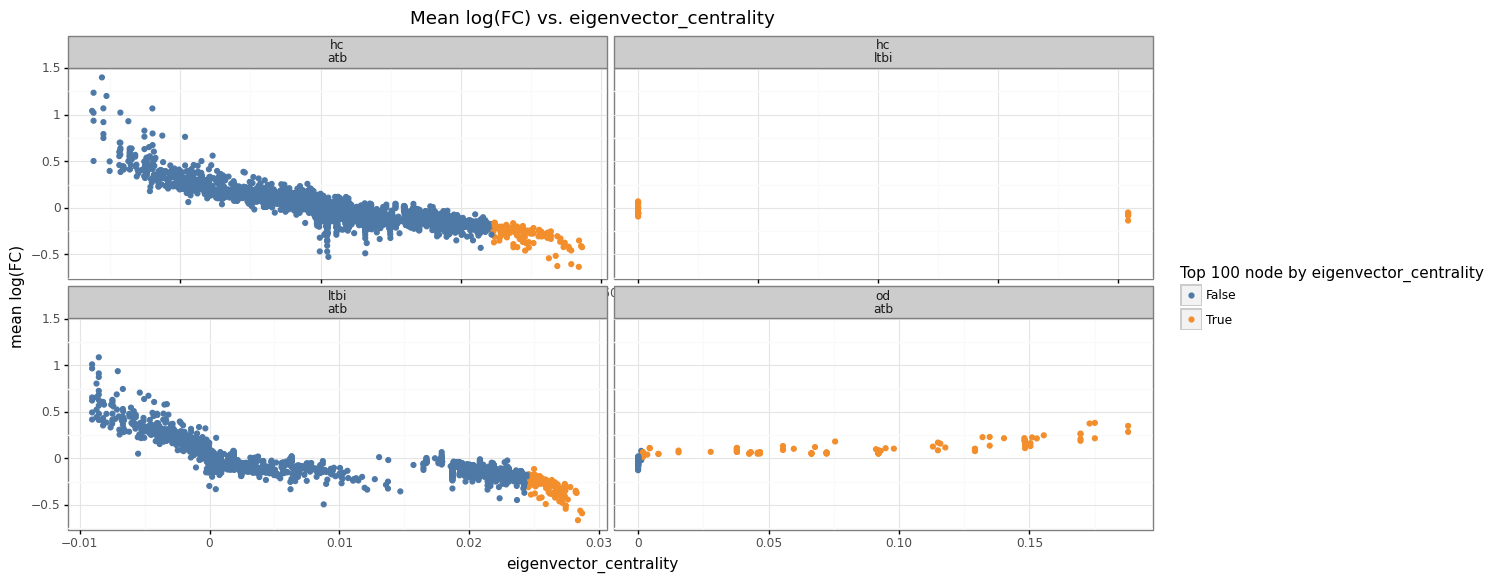

In [19]:
for measure in ['degree', 'weighted_degree', 'eigenvector_centrality']:
    tbplt.plot_mean_log_fc_vs_centrality_measure(networks['nodes'], measure=measure, top_n=100).draw();

### Generate gene lists

From the constructed gene networks, generate lists of genes found in the top
100 (as measured by weighted degree) in each comparison network.

In [20]:
gene_lists = na.generate_gene_lists(networks['nodes'], top_n=100)

#### Inspect network gene list intersections

`hc-atb` and `ltbi-atb` intersection:

In [21]:
updated = set(gene_lists['hc-atb']).intersection(set(gene_lists['ltbi-atb']))
print(updated)
with (project_dir / 'data' / 'hc_ltbi_and_ltbi_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')

{'DHRS3', 'SLFN5', 'ATP8B2', 'TRABD2A', 'SYTL2', 'FAM102A', 'ST6GALNAC6', 'FCRL2', 'TSEN54', 'LAX1', 'SKAP1', 'CNNM3', 'EPHA4', 'TCL1A', 'STAT4', 'SLC4A7', 'TBX21'}


`hc-atb`, `ltbi-atb`, and `od-atb` intersection:

In [22]:
updated = set(gene_lists['hc-atb']).intersection(set(gene_lists['ltbi-atb']), set(gene_lists['od-atb']))
with (project_dir / 'data' / 'hc_ltbi_andltbi_atb_and_od_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')
with (project_dir / 'data' / 'roger_top_genes_all_networks.txt').open('r') as f:
    roger = set([x.strip() for x in f.readlines()])
print('Updated: ', updated)
print('Roger: ', roger)
print('Updated and Roger intersection: ', updated.intersection(roger))

Updated:  set()
Roger:  {'IFIT3', 'TLR5', 'ADM', 'AIM2', 'ANKRD22', 'WARS', 'IFITM3', 'BATF2', 'CEACAM1', 'GBP4', 'DUSP3', 'XAF1', 'ANXA3', 'GBP1', 'VAMP5', 'LAP3', 'C1QB', 'SERPING1', 'EPSTI1', 'FAM26F', 'SMARCD3', 'FCGR1B', 'GBP5', 'PSTPIP2'}
Updated and Roger intersection:  set()


`hc-atb`, `ltbi-atb`, but not `od-atb`:

In [23]:
updated = set(gene_lists['hc-atb']).intersection(set(gene_lists['ltbi-atb'])) - set(gene_lists['od-atb'])
with (project_dir / 'data' / 'hc_ltbi_and_ltbi_atb_not_od_atb_intersection.gene_list.txt').open('w') as f:
    for gene in updated:
        f.write(f'{gene}\n')
with (project_dir / 'data' / 'roger_top_genes_not_in_od_network.txt').open('r') as f:
    roger = [x.strip() for x in f.readlines()]
print('Updated: ', updated)
print('Roger: ', roger)
print('Updated and Roger intersection: ', updated.intersection(roger))

Updated:  {'DHRS3', 'ATP8B2', 'SYTL2', 'FAM102A', 'STAT4', 'ST6GALNAC6', 'FCRL2', 'TSEN54', 'LAX1', 'SKAP1', 'CNNM3', 'EPHA4', 'TBX21', 'TCL1A', 'SLFN5', 'SLC4A7', 'TRABD2A'}
Roger:  ['TNFSF10', 'DYSF', 'IL1B', 'GK', 'LHFPL2', 'TRIM22', 'CLEC4D', 'TNFSF13B', 'PLAUR', 'LY96', 'FBXO6', 'KCNJ15', 'SPOCK2', 'TMEM204', 'IL7R', 'GPR183', 'ID3', 'CD6', 'KLRB1', 'PIK3IP1', 'CCR7', 'NELL2', 'SKAP1']
Updated and Roger intersection:  {'SKAP1'}


### Plot effect size heatmaps across gene sets and comparison networks

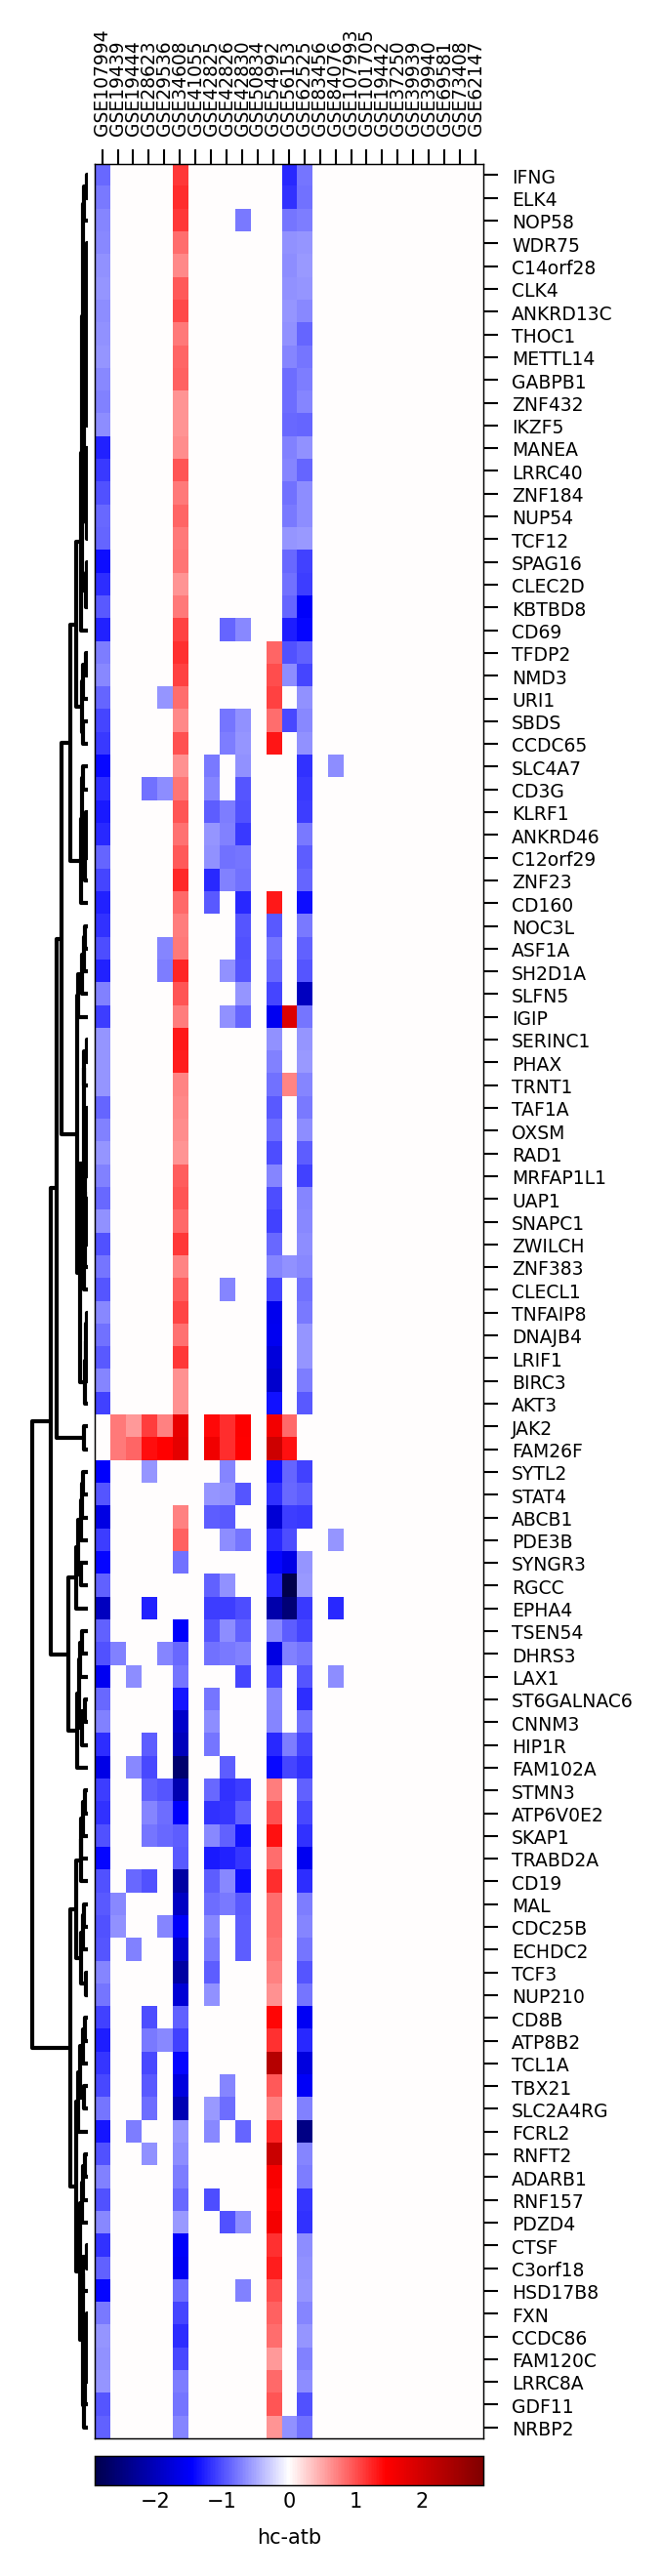

In [24]:
tbplt.plot_log_fc_heatmap(
    merged_results,
    gene_set=gene_lists['hc-atb'],
    control='hc', case='atb')

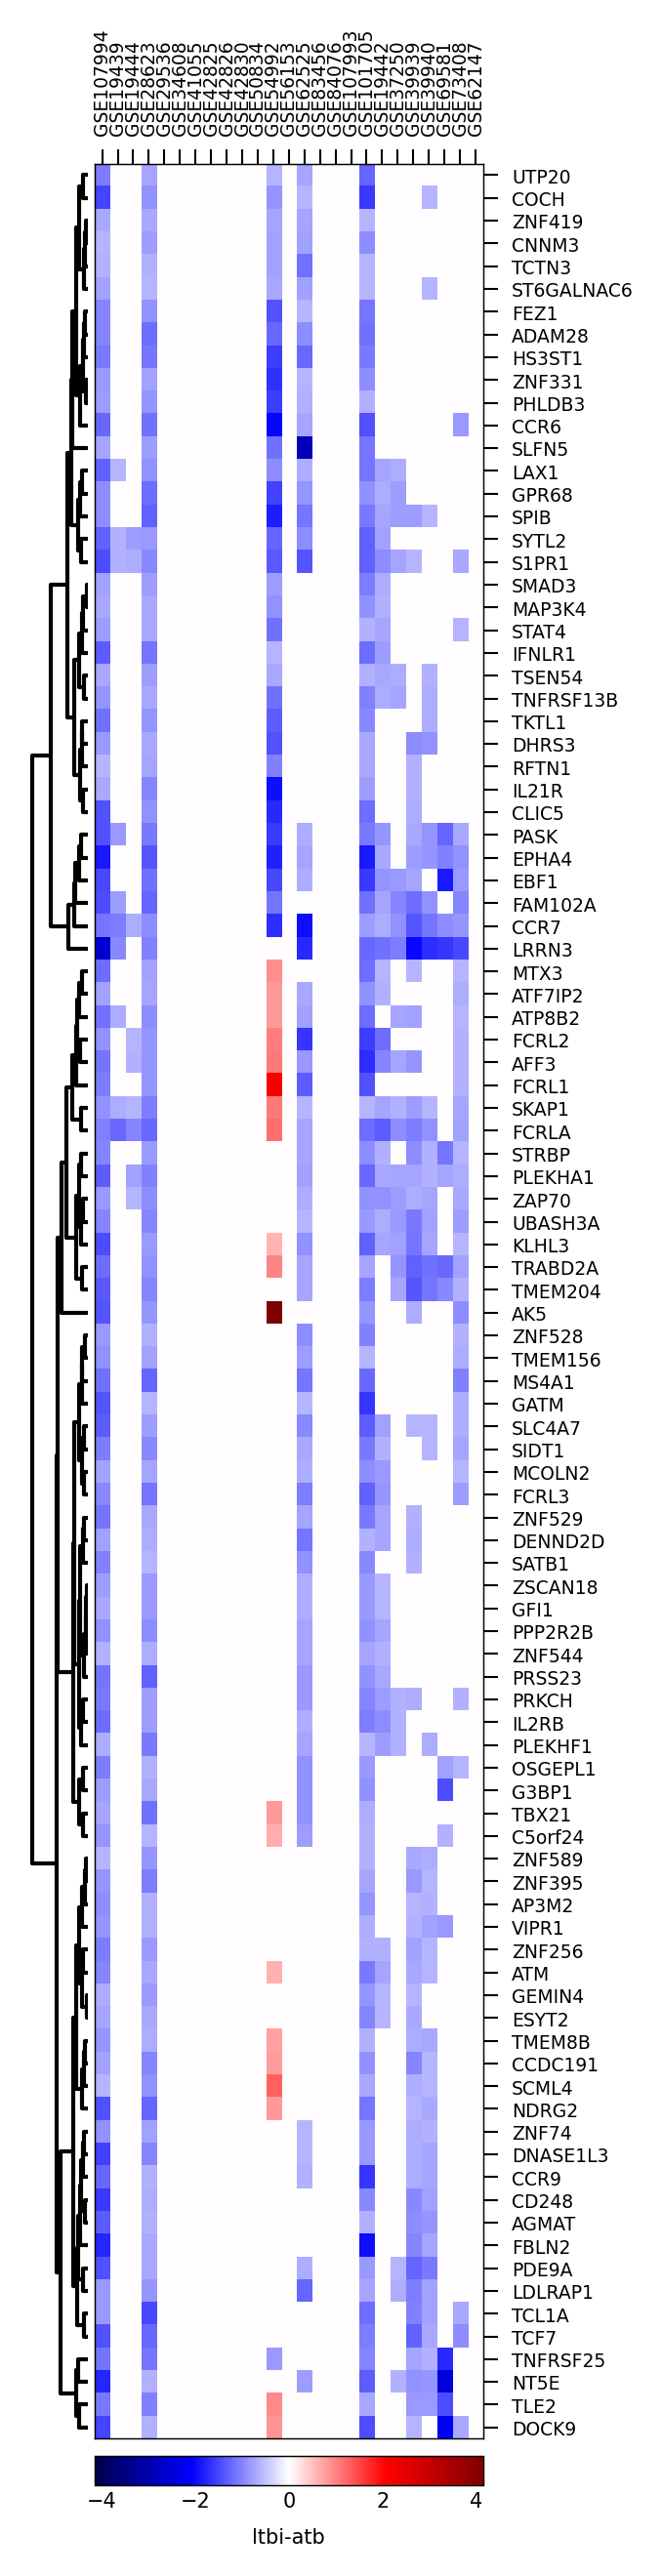

In [25]:
tbplt.plot_log_fc_heatmap(
    merged_results,
    gene_set=gene_lists['ltbi-atb'],
    control='ltbi', case='atb')

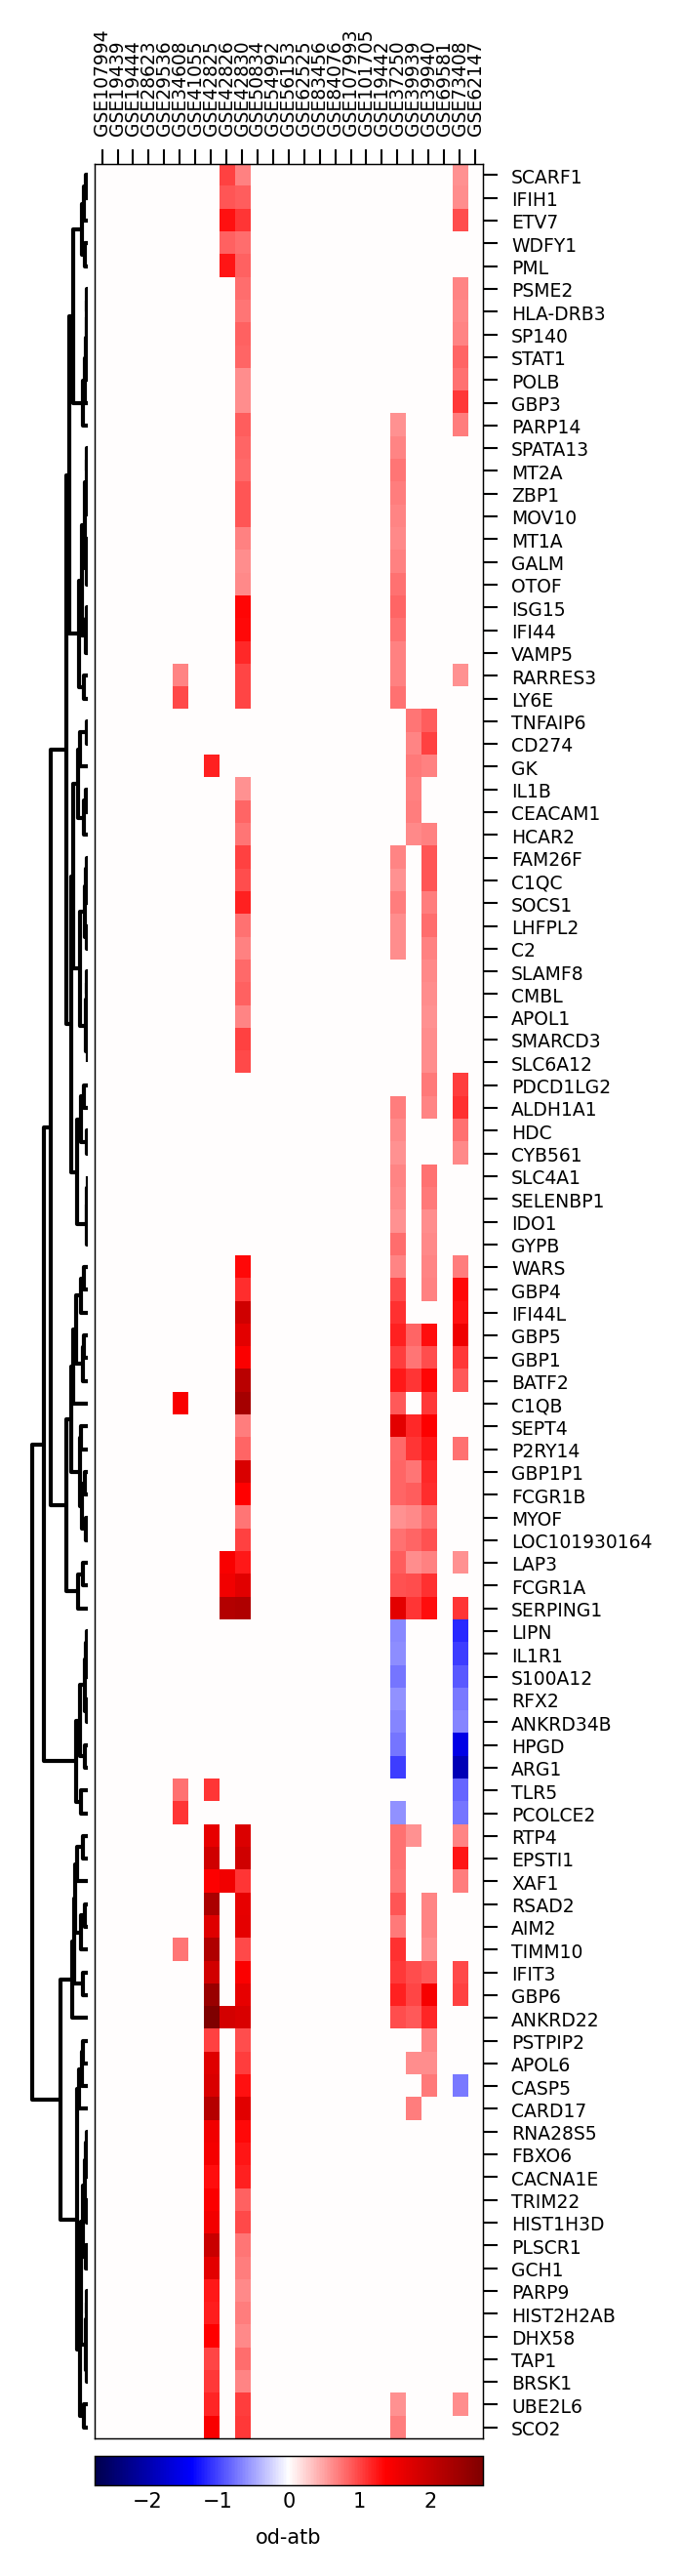

In [26]:
tbplt.plot_log_fc_heatmap(
    merged_results,
    gene_set=gene_lists['od-atb'],
    control='od', case='atb')